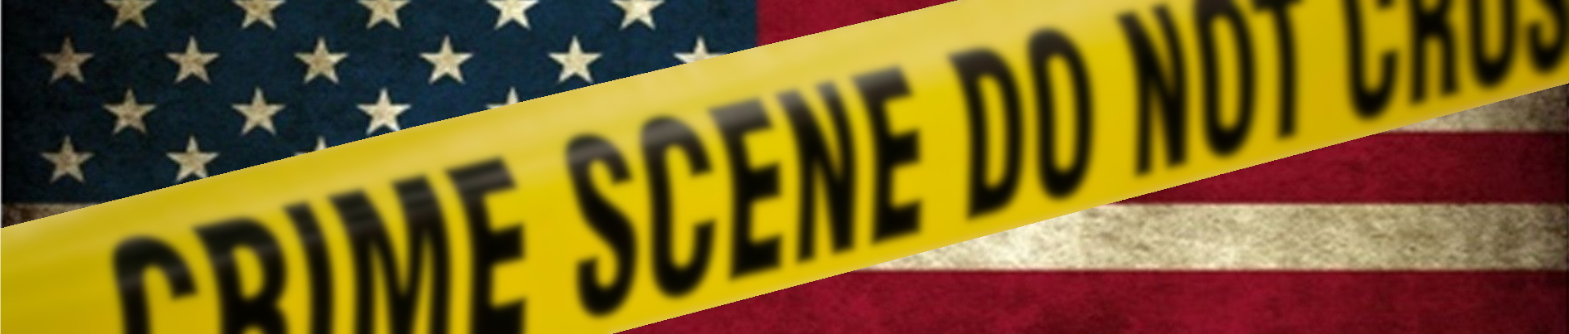

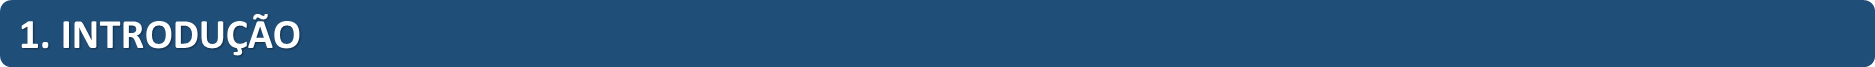

### **Machine Learning - Não Supervisionado - Clusterização**
  

*Dataset* disponível no [Kaggle](https://www.kaggle.com/rupakroy/crime-data) com o intuito de aplicação de técnicas de Clusterização.

O *Dataset* possui 50 registros, representando os cinquentas estados dos Estados Unidos da América, cada registro possui 6 colunas, sendo uma delas para validação do modelo aplicado.

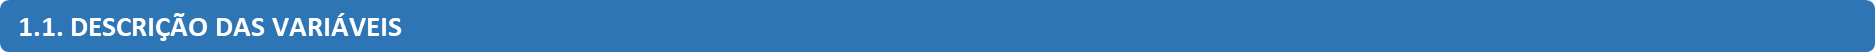

|      Feature      	|             **Description**            	|
|:-----------------:	|:--------------------------------------:	|
|     **State**     	|             Name of State.             	|
| **crime$cluster** 	|     Cluster labels for validation.     	|
|     **Murder**    	|             Total records.             	|
|    **Assault**    	|             Total records.             	|
|    **UrbanPop**   	| An estimation of the urban population. 	|
|      **Rape**     	|              No. of cases.             	|

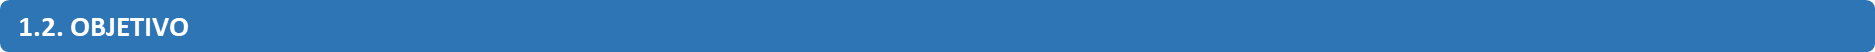

Realizar uma breve exploração dos dados disponibilizados para posteriormente aplicar e treinar dois modelos de *Machine Learning* (*KMeans* e *AgglomerativeClustering*) visando obter 100% de acurácia com relação à variável *target* 'crime$cluster'. Ao final expor os resultados e observações encontradas durante o processo.

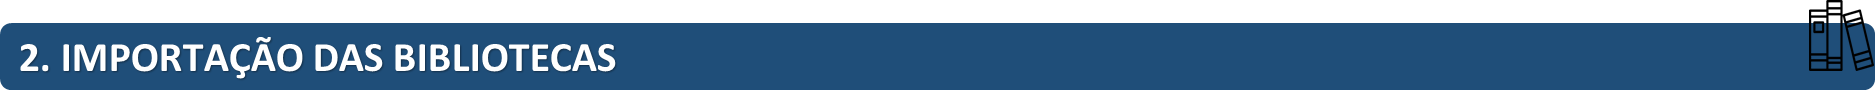

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
import folium
from folium import plugins
import json
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

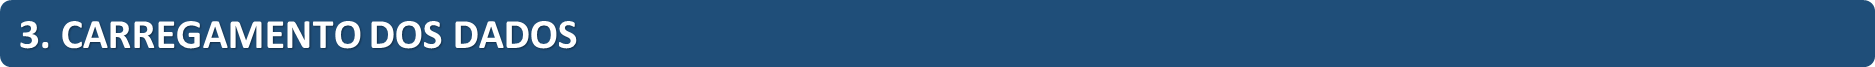

In [2]:
df_crime = pd.read_csv('Arquivos/crime_data.csv')

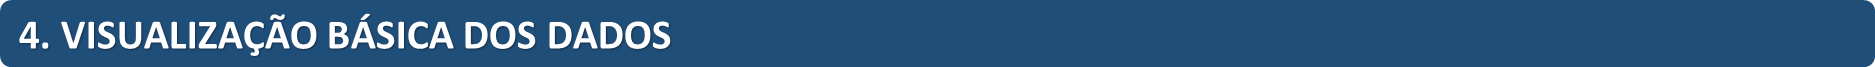

In [3]:
df_crime.head(2)

,State,crime$cluster,Murder,Assault,UrbanPop,Rape
0,Alabama,4,13.2,236,58,21.2
1,Alaska,4,10.0,263,48,44.5


In [4]:
df_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State          50 non-null     object 
 1   crime$cluster  50 non-null     int64  
 2   Murder         50 non-null     float64
 3   Assault        50 non-null     int64  
 4   UrbanPop       50 non-null     int64  
 5   Rape           50 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 2.5+ KB


***
* Apenas a coluna 'State' (Nome do Estado) não é numérica;
* Em que pese a coluna 'crime$cluster' constar como numérica, podemos dizer que ela é uma variável qualitativa nominal;
* Não há valores ausentes no *Dataset*.
***

In [5]:
display(df_crime.describe(), df_crime.describe(include='O'))

,crime$cluster,Murder,Assault,UrbanPop,Rape
count,50.000000,50.00000,50.000000,50.000000,50.000000
mean,2.720000,7.78800,170.760000,65.540000,21.232000
std,1.125584,4.35551,83.337661,14.474763,9.366385
min,1.000000,0.80000,45.000000,32.000000,7.300000
25%,2.000000,4.07500,109.000000,54.500000,15.075000
50%,3.000000,7.25000,159.000000,66.000000,20.100000
75%,4.000000,11.25000,249.000000,77.750000,26.175000
max,4.000000,17.40000,337.000000,91.000000,46.000000


,State
count,50
unique,50
top,Alabama
freq,1


***
* Não há registros duplicados no *Dataset*.
***

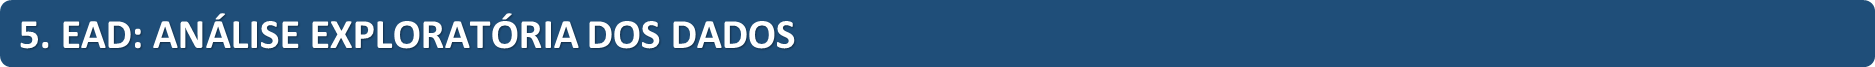

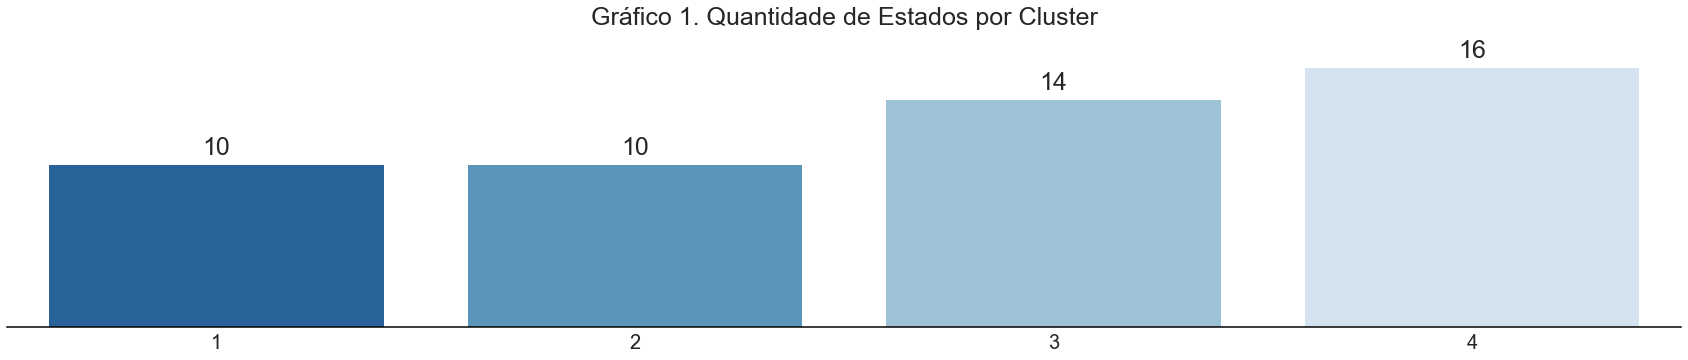

In [6]:
# Plotagem do gráfico com a quantidade de estados por cluster.
fig, ax = plt.subplots(figsize=(30, 5))

sns.countplot('crime$cluster', data=df_crime, palette='Blues_r')
ax.tick_params(axis='y', labelleft=False, grid_alpha=0.0), ax.tick_params(axis='x', labelsize=20)
ax.set_ylabel(''), ax.set_xlabel('')
ax.set_title('Gráfico 1. Quantidade de Estados por Cluster', fontsize=25, pad=30)
ax.spines['bottom'].set_linewidth(1.5), ax.spines['bottom'].set_color('black')
for axis in ['top', 'right', 'left']:    ax.spines[axis].set_color(None)
    
for i in ax.patches:
    ax.annotate('{:,}'.format(int(i.get_height())),
    (i.get_x() + i.get_width() / 2, i.get_height()),
    ha='center', va='baseline', xytext=(0,10),
    textcoords='offset points', fontsize=25) 

***
* Podemos observar no gráfico acima que os grupos estão bem distribuídos. Vamos fazer uma análise mais profunda logo adiante para identificarmos as diferenças entre eles.
***

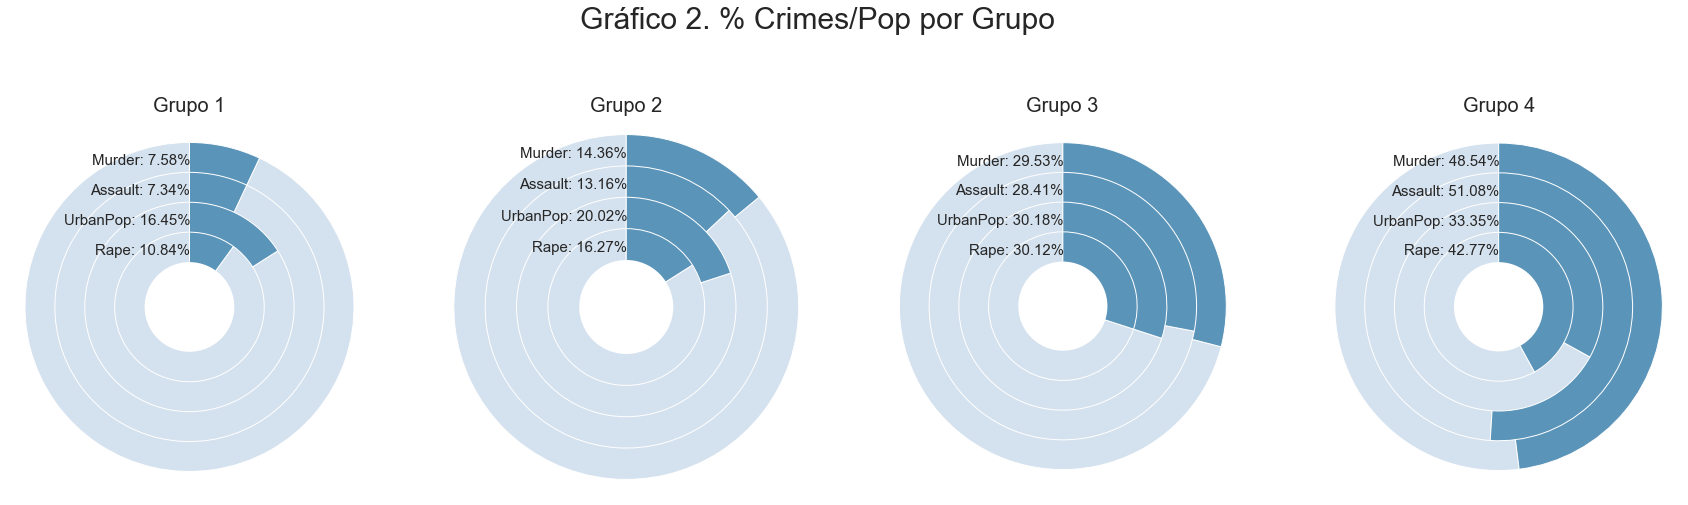

In [7]:
# Plotagem do gráfico 2. Relacionando a porcentagem de crime/pop de cada grupo.
listMurderPerc = [df_crime.Murder[df_crime['crime$cluster'] == grupo].sum() / df_crime.Murder.sum() for grupo in sorted(df_crime['crime$cluster'].unique())]
listAssaultPerc = [df_crime.Assault[df_crime['crime$cluster'] == grupo].sum() / df_crime.Assault.sum() for grupo in sorted(df_crime['crime$cluster'].unique())]
listUrbanPopPerc = [df_crime.UrbanPop[df_crime['crime$cluster'] == grupo].sum() / df_crime.UrbanPop.sum() for grupo in sorted(df_crime['crime$cluster'].unique())]
listRapePerc = [df_crime.Rape[df_crime['crime$cluster'] == grupo].sum() / df_crime.Rape.sum() for grupo in sorted(df_crime['crime$cluster'].unique())]

figura = plt.figure(figsize=(30, 7))
figura.suptitle(f'Gráfico 2. % Crimes/Pop por Grupo', fontsize=30, y=1.1)
for grupo in sorted(df_crime['crime$cluster'].unique()):
    figura.add_subplot(1, 4, grupo)
    listaTempDiversos = [['Murder:', round(listMurderPerc[grupo-1]*100,2)], 
                         ['Assault:', round(listAssaultPerc[grupo-1]*100,2)], 
                         ['UrbanPop:', round(listUrbanPopPerc[grupo-1]*100,2)], 
                         ['Rape:', round(listRapePerc[grupo-1]*100,2)]]

    dfTemp = pd.DataFrame(np.array(listaTempDiversos).reshape(4,2), columns = ['Crime', 'Perc.'])
    startingRadius = 0.7 + (0.5* (len(dfTemp)-1))
    for index, row in dfTemp.iterrows():
        scenario = row['Crime']
        percentage = row['Perc.']
        textLabel = scenario + ' ' + percentage + '%'    
        percentage = int(re.search(r'\d+', percentage).group())
        remainingPie = 100 - percentage
        donut_sizes = [remainingPie, percentage]
        plt.text(0.01, startingRadius - 0.15, textLabel, horizontalalignment='right', verticalalignment='top', fontsize=15)
        plt.pie(donut_sizes, radius=startingRadius, startangle=90, colors=['#d4e1ee', '#5a94b9'],
                wedgeprops={"edgecolor": "white", 'linewidth': 1})
        startingRadius-=0.4    
    plt.title(f'Grupo {grupo}', fontsize=20)
    circle = plt.Circle(xy=(0, 0), radius=0.6, facecolor='white')
    plt.gca().add_artist(circle)
    plt.axis('equal');

***
* Fica evidente que os grupos estão distribuídos de acordo com a quantidade de crimes cometidos. A imagem acima deixa claro a diferença de crimes cometidos e registrados entre cada grupo de estados.
 * Grupo 1: Estados com índices baixos de criminalidade, os mais "tranquilos";
 * Grupo 2: Com uma porcentagem maior de população podemos observar que os índices aumentam;
 * Grupo 3: Há um aumento significativo na taxa de criminalidade em relação ao grupo anterior;
 * Grupo 4: Estados com a maior taxa de crimes, acompanhando o porcentagem da população.
* Nota-se que quanto maior a variável 'UrbanPop' maiores são os índices de criminalidade.
***


In [8]:
# Carregamento dos dados do arquivo Json para posterior plotagem no mapa
geo = json.load(open('Arquivos/statesUSA.json'))

In [9]:
# Função para adicionar as legendas nos mapas
def gerarDados(arqGeo, listaColunas, df):
    for i in range(50):
        for j in listaColunas:
            estado = arqGeo['features'][i]['properties']['NAME']
            arqGeo['features'][i]['properties'][j] = float(df[j][df.State == estado].values[0])

gerarDados(geo, ['Murder', 'Assault', 'UrbanPop', 'Rape', 'crime$cluster'], df_crime)

In [10]:
# Criação e plotagem dos mapas de calor
mapa = folium.Map(location=[45, -95], zoom_start=5.15, tiles=None, scrollWheelZoom=False, dragging=False, prefer_canvas=False, overlay=False)

listFigs = [[folium.FeatureGroup(name='Murder', overlay=False).add_to(mapa),'Murder','Blues','No. of Cases: '],
            [folium.FeatureGroup(name='Assault',overlay=False).add_to(mapa),'Assault','Blues','No. of Cases: '],
            [folium.FeatureGroup(name='Urban Pop',overlay=False).add_to(mapa),'UrbanPop','Blues','No. of Cases: '],
            [folium.FeatureGroup(name='Rape', overlay=False).add_to(mapa),'Rape','Blues','No. of Cases '],
            [folium.FeatureGroup(name='Cluster',overlay=False).add_to(mapa),'crime$cluster','Pastel1','Cluster: ']]

for i, figura in enumerate(listFigs):
    item = listFigs[i][1]
    alias = listFigs[i][3]
    i = folium.Choropleth(geo_data=geo,
                          data=df_crime,
                          columns=['State', listFigs[i][1]],
                          key_on='properties.NAME',
                          fill_color=listFigs[i][2],
                          fill_opacity=1,
                          line_color='white',
                          line_opacity=1,
                          highlight=True).geojson.add_to(listFigs[i][0])
    
    folium.features.GeoJson(data=geo,
                            name='teste',
                            smooth_factor=1,
                            style_function=lambda x: {'color': 'black','fillColor': 'transparent','weight': 0.5},
                            tooltip=folium.features.GeoJsonTooltip(fields=['NAME', item],
                                                                   aliases=['State: ', alias],
                                                                   sticky=False,
                                                                   labels=True,
                                                                   style="background-color: #F0EFEF; border: 1.5px solid black; border-radius: 1px; box-shadow: 3px; font-size: 18px",
                                                                   max_width=800),
                            highlight_function=lambda x: {'weight': 2,'fillColor': 'white'}).add_to(i)

folium.TileLayer('cartodbpositron', overlay=True, control=False).add_to(mapa)
folium.LayerControl(collapsed=False).add_to(mapa);
#mapa.save("Arquivos/mapaCrimes.html")
#mapa

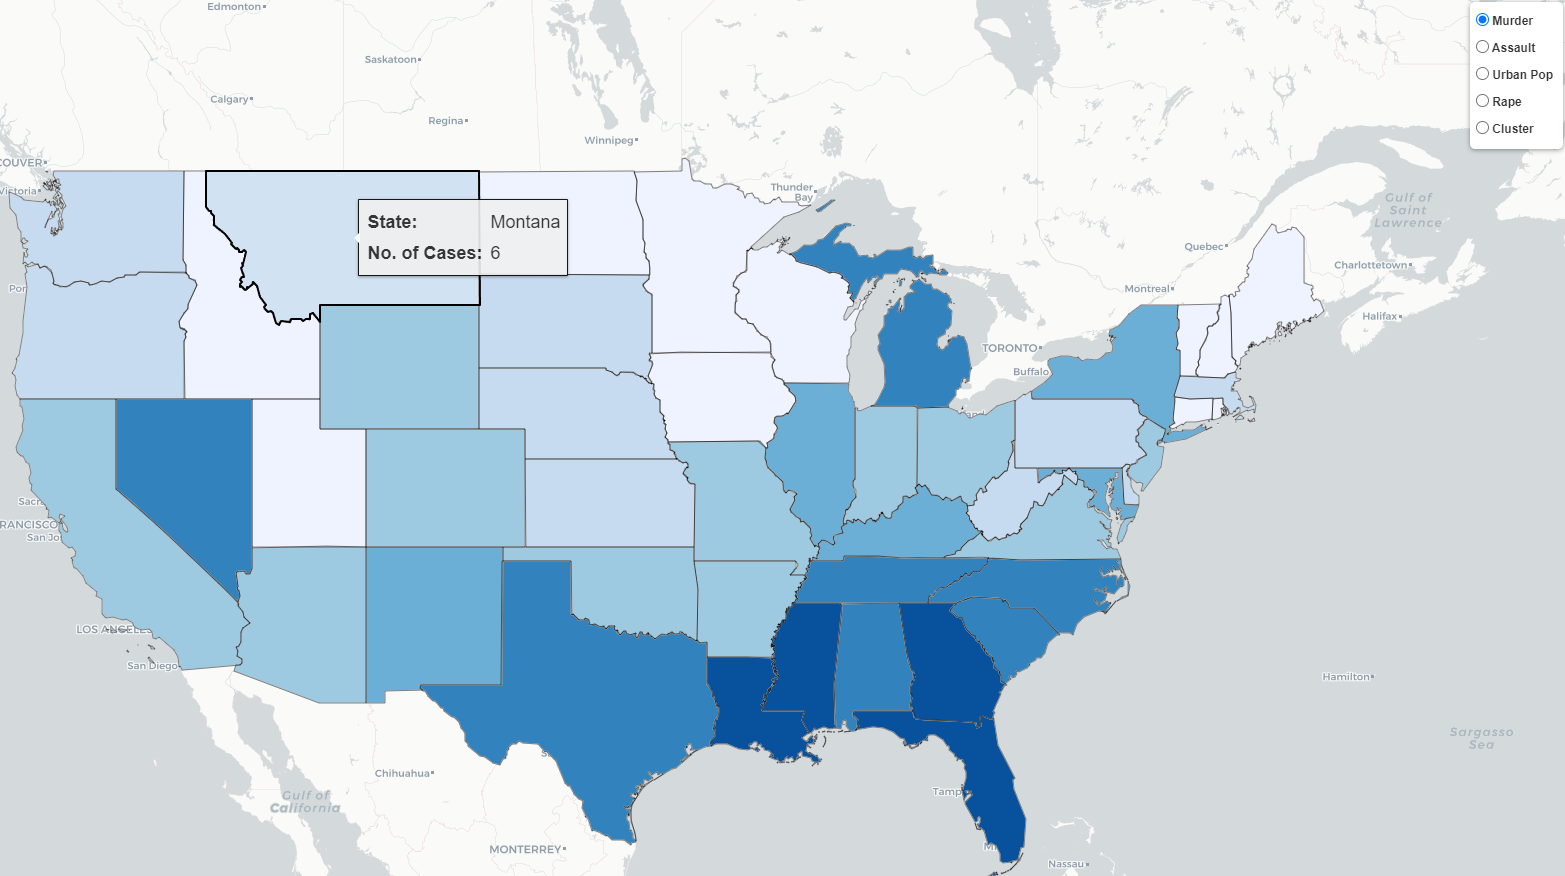

> Mapa Coroplético representando a taxa de homícidios dos Estados.

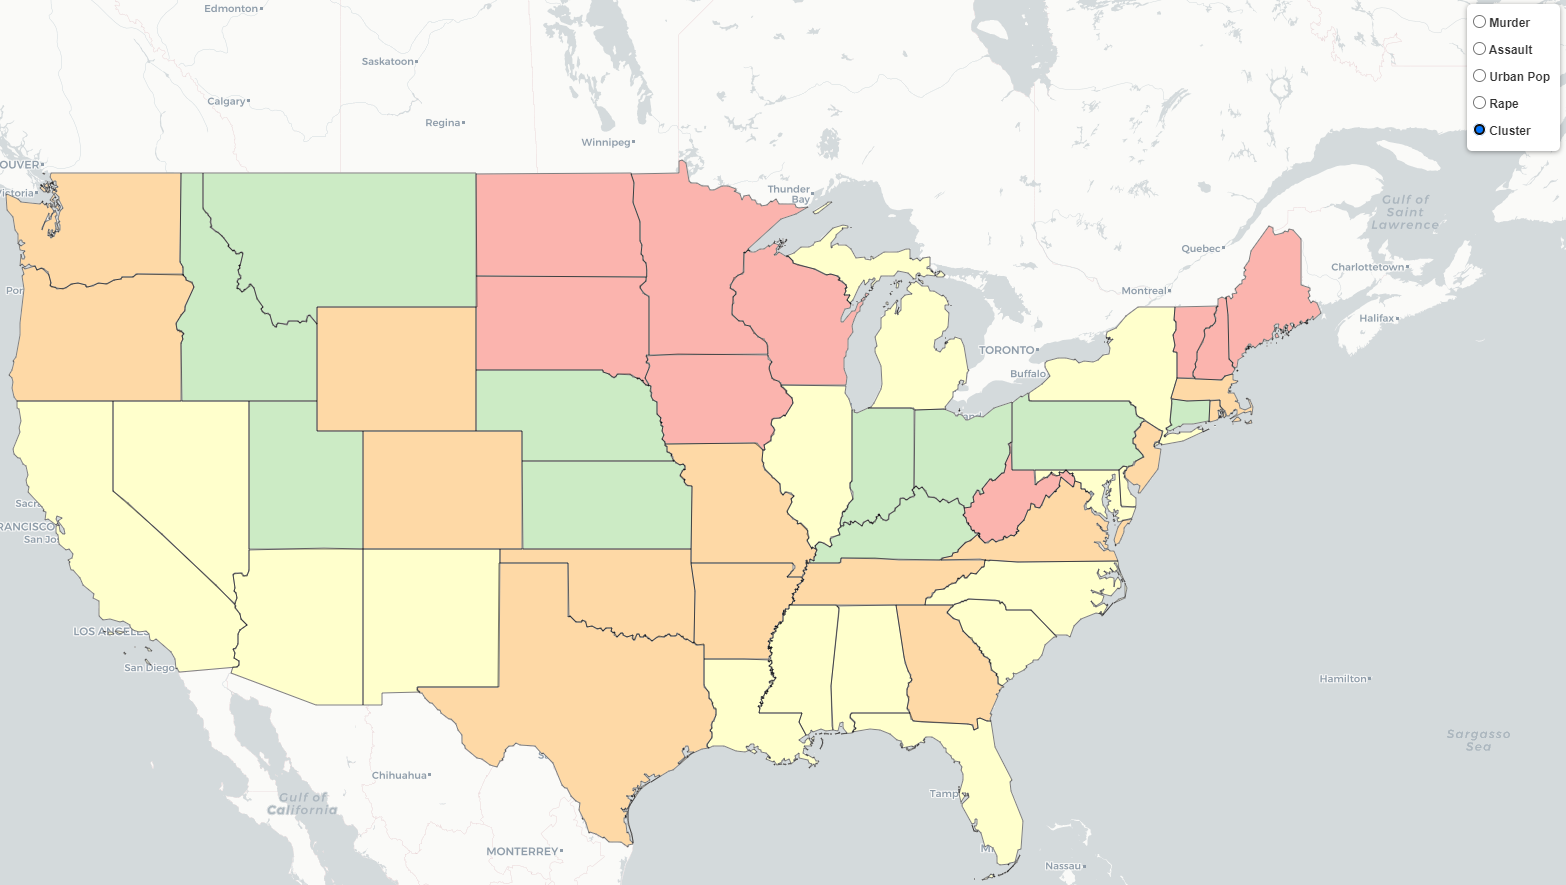

> Mapa Coroplético representando o grupo a que cada Estado pertence.

***
* Em razão do tamanho do arquivo gerado, comentei a linha 38 -> (#mapa), do código acima. E inseri as imagens acima para representar;
* Caso queira rodar, remover o comentário da linha mencionada.
***

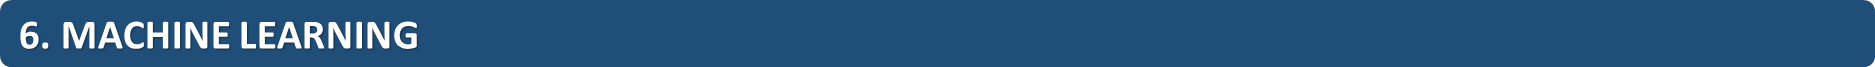

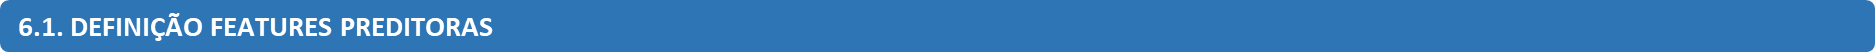

In [11]:
X = df_crime.drop(['State', 'crime$cluster'], axis=1)
print(f'A variável preditora possui {X.shape[1]} colunas.')

A variável preditora possui 4 colunas.


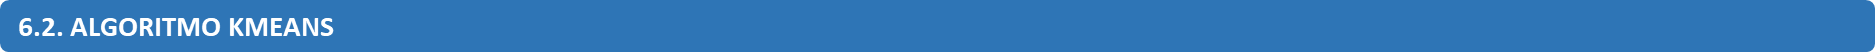

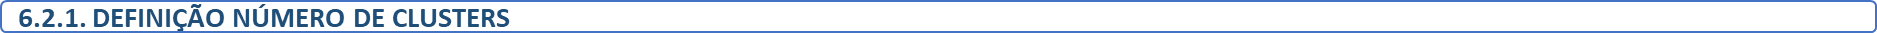

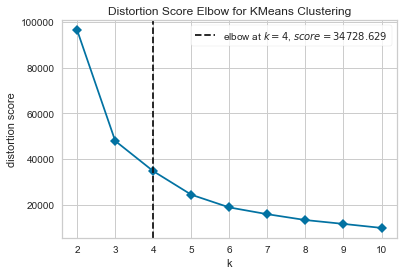

In [12]:
el = KElbowVisualizer(KMeans(), k=10, timings=False)
el.fit(X)
el.show();

***
**1.** Observa-se o número indicado de 4 *clusters* que utilizaremos na etapa seguinte.
***

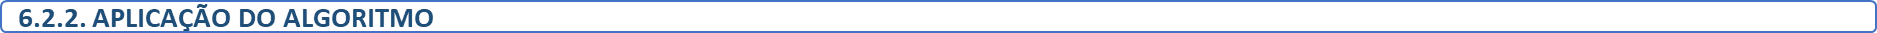

In [13]:
# Instanciando e treinando o modelo.
KM = KMeans(n_clusters=el.elbow_value_, random_state=0)
clusterKM = KM.fit_predict(X)

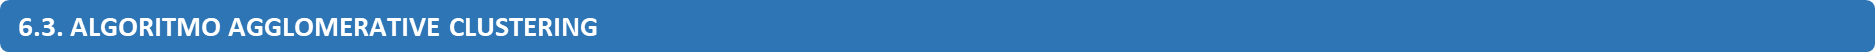

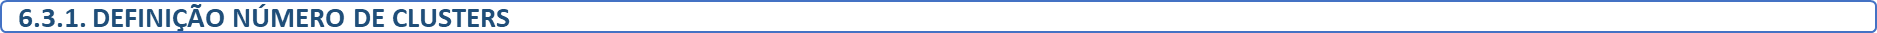

(None, None)

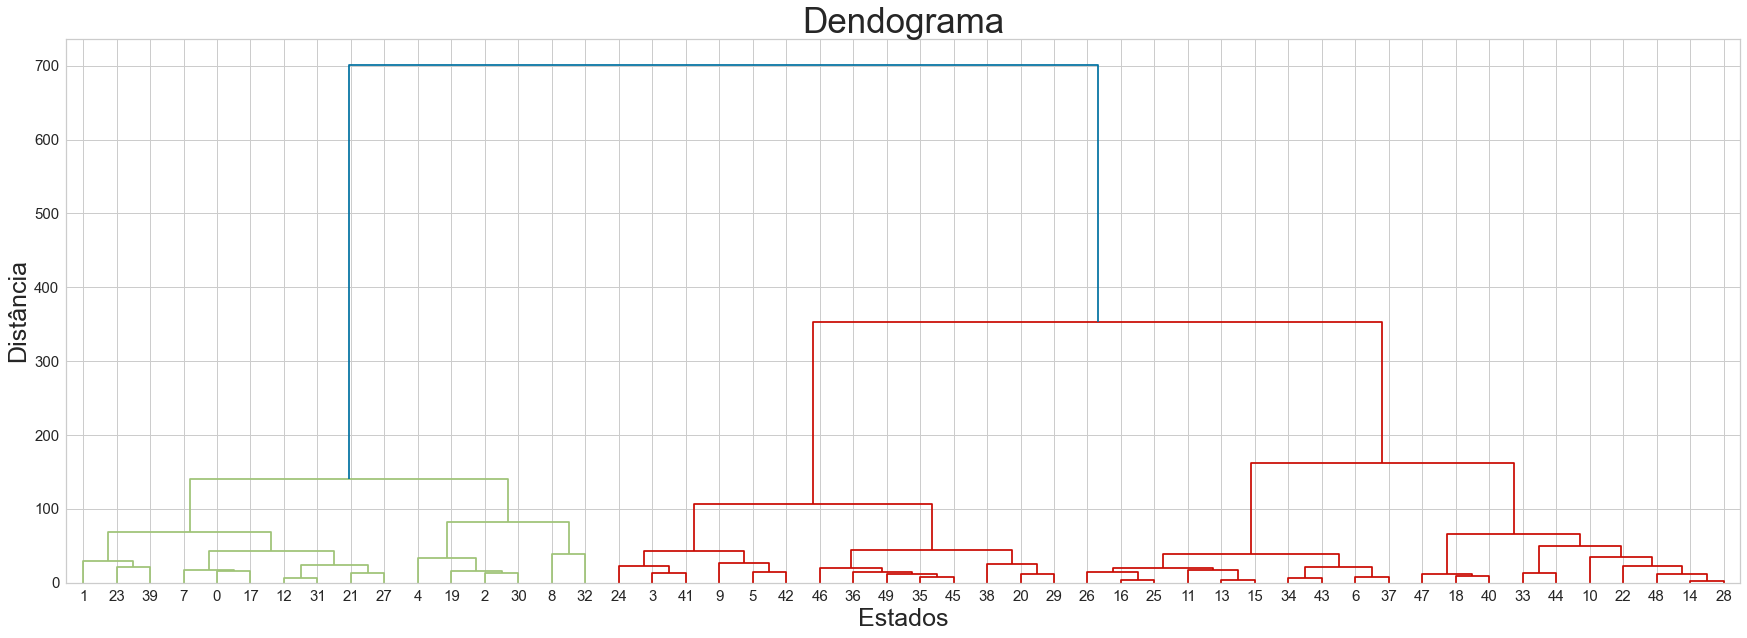

In [14]:
figura = plt.figure(figsize=(30, 10))
dendograma = dendrogram(linkage(X, method='ward'))
plt.title('Dendograma', fontsize=35), plt.xlabel('Estados', fontsize=25), plt.ylabel('Distância', fontsize=25);
plt.tick_params(axis='y', labelsize=15), plt.tick_params(axis='x', labelsize=15, labelrotation=0)

***
**1.** Utilização do método 'ward' que utiliza a mínima variância, na qual a medida de distância entre dois *clusters* será a soma das distâncias ao quadrado entre eles.

**2.** Podemos observar que o número indica de *clusters* é 4.
***

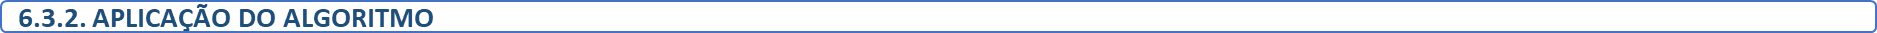

In [15]:
# Instanciando e treinando o modelo.
AC = AgglomerativeClustering(n_clusters=4, linkage='ward', affinity='euclidean')
clusterAC = AC.fit_predict(X)

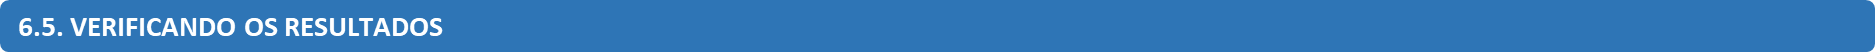

In [16]:
# Criação de novas colunas no DataFrame com o resultado obtido pela aplicação dos algoritmos.
df_crime.loc[:, 'ClusterKM'] = clusterKM
df_crime.loc[:, 'ClusterAC'] = clusterAC

In [17]:
# Criação das listas com os estados pertencentes a seu respectivo Cluster.
listaClusterValidacao = [list(df_crime.groupby('crime$cluster').get_group(grupo).State.values) for grupo in df_crime['crime$cluster'].unique()]
listaClusterKM = [list(df_crime.groupby('ClusterKM').get_group(grupo).State.values) for grupo in df_crime['ClusterKM'].unique()]
listaClusterAC = [list(df_crime.groupby('ClusterAC').get_group(grupo).State.values) for grupo in df_crime['ClusterAC'].unique()]

In [18]:
# Criação da função para comparação das listas.
def compararListas(l1, l2):
    return [True if(set(l1[lista]) == set(l2[lista])) else False for lista in range(len(listaClusterValidacao))]

In [19]:
# Comparação listaValidação com resultado do algoritmo KMeans.
compararListas(listaClusterValidacao, listaClusterKM)

[True, True, True, True]

In [20]:
# Comparação listaValidação com resultado do algoritmo KMeans.
compararListas(listaClusterValidacao, listaClusterAC)

[True, True, True, True]

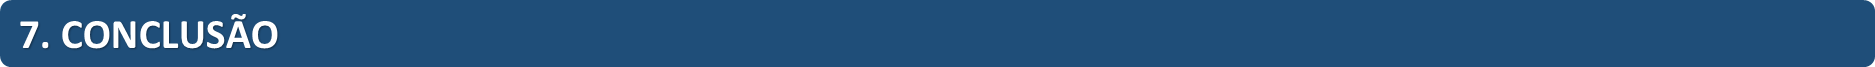

***
* Conseguimos obter 100% de acurácia com a utilização dos dois tipos de algoritmos propostos (*KMeans* e *AgglomerativeClustering*), conforme observado na etapa **"6.5. Verificando os Resultados"**.

* Não foi necessário realizar o escalonamento das *features* tampouco a técnica de Análise de Componentes Principais (PCA), usada para analisar e explicar as inter-relações entre um grande número de variáveis, haja vista o *Dataset* possuir poucos atributos.

* Em que pese o mencionado acima, com relação à quantidade de atributos, acredito que pude expor aqui os conhecimentos adquiridos, tendo assim um resultado satisfatório.
***

|                 **Github**                	|                 **Linkedin**                 	|                  **Kaggle**                  	|               **Email**              	|
|:-----------------------------------------:	|:--------------------------------------------:	|:--------------------------------------------:	|:------------------------------------:	|
| [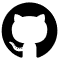](https://www.github.com/ThiagoFerreiraWD) 	| [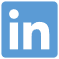](https://www.linkedin.com/in/tferreirasilva) 	| [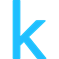](https://www.kaggle.com/thiagoferreirasilva) 	| [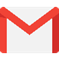](mailto:thiago.ferreirawd@gmail.com) 	|